<a href="https://colab.research.google.com/github/nirb28/nn_catalyst/blob/main/src/pl/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def resolve_path_gdrive(relativePath, localPathPrefix=""):
    if os.path.exists('/content/drive'):
        return '/content/drive/MyDrive/work/gdrive-workspaces/git/ee-predict/' + relativePath
    else:
        return localPathPrefix + relativePath
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np, os

# import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import the dataset from the csv file.
df = pd.read_csv(resolve_path_gdrive('data/merged_large_catalyst.csv', localPathPrefix="../"))

In [ ]:
# This is a problem as our n << p
# And if p > n, then there is no longer a unique least squares coefficient estimate.
# Least squares will not be a
print(df.shape)
df = df[df.ddG != 0]
print(df.shape)
#df.columns #= [*df.columns[:-1], 'ddG']
df.head()

(1850, 3976)
(319, 3976)


,Catalyst,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,3876,3877,3878,3879,3880,3881,3882,3883,3884,3885,3886,3887,3888,3889,3890,3891,3892,3893,3894,3895,3896,3897,3898,3899,3900,3901,3902,3903,3904,3905,3906,3907,3908,3909,3910,3911,3912,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952,3953,3954,3955,3956,3957,3958,3959,3960,3961,3962,3963,3964,3965,3966,3967,3968,3969,3970,3971,3972,3973,3974,ddG
0,1_1_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0625,0.062500,0.0,0.0,-0.062500,0.0,-0.149000,0.0,-0.025,0.0125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.062500,0.062500,0.0,-0.062500,-0.062500,-0.0125,-0.0875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0125,0.0,0.0,1.192046,0.575046,1.267794,1.190427,1.005503,-0.429561,-0.819943,-1.060149,-0.944026,-0.177977,-0.893660,-0.833714,-0.605952,-0.471700,-0.768480,-0.178536,-0.298590,-0.238640,-0.277510,-0.230633,-0.672194,1.226289
1,1_1_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0625,0.062500,0.0,0.0,-0.062500,0.0,-0.149000,0.0,-0.025,0.0125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.062500,0.062500,0.0,-0.062500,-0.062500,-0.0125,-0.0875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0125,0.0,0.0,-0.900772,-1.204402,-1.127398,-1.106008,-1.172227,-0.263889,0.546659,0.579985,0.564909,-0.159928,-0.875422,-0.880495,-0.602624,-0.471616,-0.798242,-0.277709,-0.280445,-0.279338,-0.246094,-1.153164,-1.146684,0.719002
10,1_11_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032143,-0.010714,0.0,0.0,0.0,0.0,-0.064286,-0.010714,0.0,0.0,0.0,-0.010714,0.0,0.0,0.0,0.0000,-0.021429,0.0,0.0,0.064286,0.0,0.053571,0.0,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010714,0.0,0.0,-0.064286,-0.064286,0.0,-0.032143,-0.064286,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,1.192046,0.575046,1.267794,1.190427,1.005503,-0.429561,-0.819943,-1.060149,-0.944026,-0.177977,-0.893660,-0.833714,-0.605952,-0.471700,-0.768480,-0.178536,-0.298590,-0.238640,-0.277510,-0.230633,-0.672194,0.631877
16,1_2_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

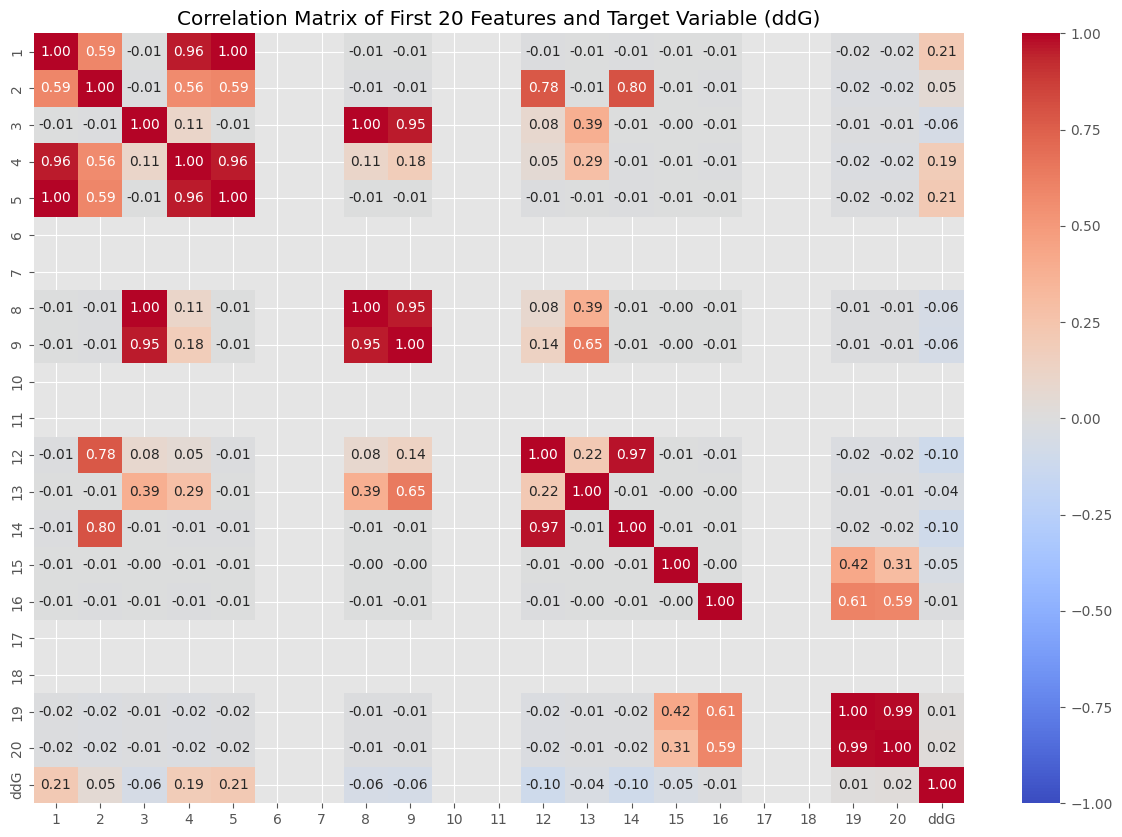

In [ ]:
# Compute the correlation matrix for the first 20 features and the target variable to keep it manageable
correlation_matrix = df.iloc[:, 1:21].join(df['ddG']).corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of First 20 Features and Target Variable (ddG)")
plt.show()

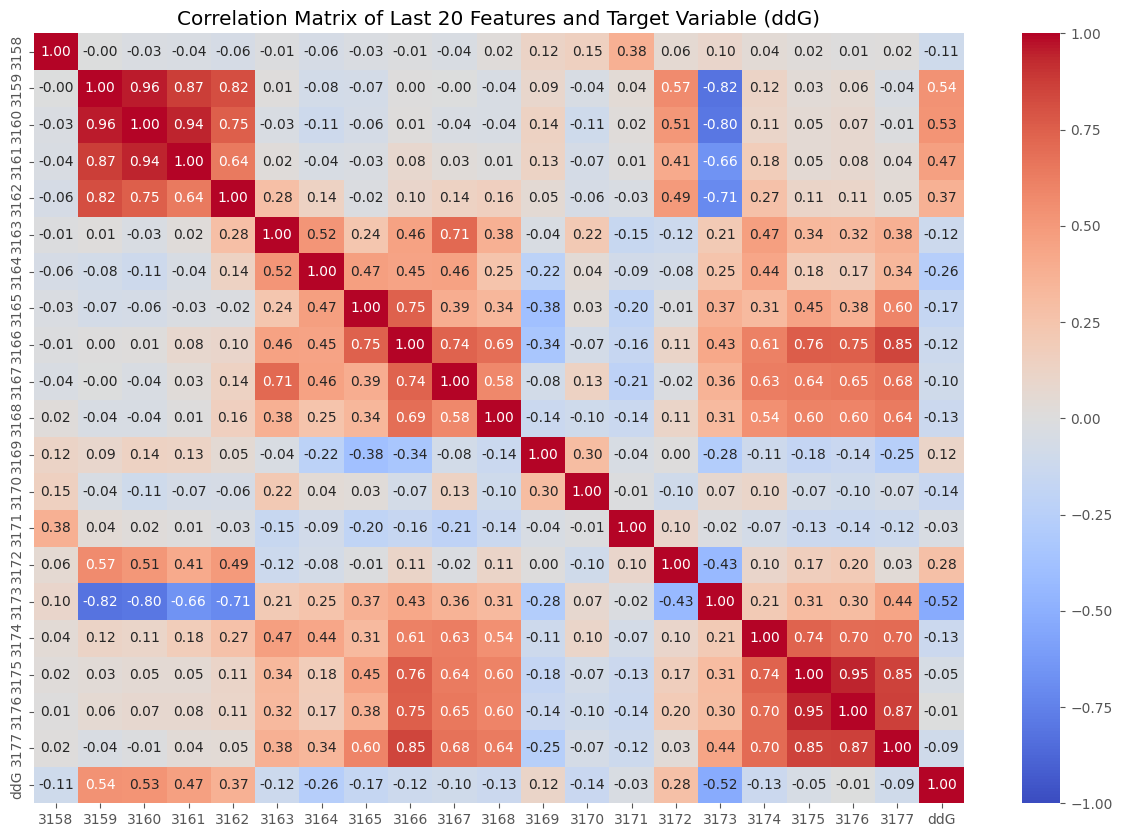

In [ ]:
# Compute the correlation matrix for the last 20 features and the target variable to keep it manageable
correlation_matrix = df.iloc[:, 3158:3178].join(df['ddG']).corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Last 20 Features and Target Variable (ddG)")
plt.show()

In [ ]:
corr_table = df[df.iloc[:, 1:3974].columns].corrwith(df['ddG'])
# prompt: find rows in corr_table where corr > .5
high_corr_rows = corr_table[abs(corr_table) > .5]
print(len(high_corr_rows.keys()))
high_corr_rows.keys()

62


Index(['906', '907', '908', '922', '923', '937', '950', '951', '952', '1113',
       '1128', '1129', '1130', '1156', '1157', '1158', '1172', '1173', '1174',
       '1190', '1331', '1332', '1346', '1347', '1359', '1360', '1372', '1388',
       '1404', '1405', '1536', '1537', '1553', '1554', '1555', '1567', '1728',
       '1743', '1745', '1771', '1870', '1970', '1980', '1981', '2009', '2111',
       '2135', '2912', '2958', '3103', '3159', '3160', '3173', '3524', '3525',
       '3547', '3548', '3628', '3688', '3916', '3940', '3951'],
      dtype='object')

In [ ]:
f = open(resolve_path_gdrive("models/high_corr_cols.txt"), "w")
for key in high_corr_rows.keys():
  f.write('{},'.format(key))
f.close()

## PCA
Here we implement methods that reduce the number of parameters


Logistic Regression model with all features

In [ ]:
## Use all columns except ddG and Catalyst
#X = df.drop(['Catalyst', 'ddG'], axis=1)
## Use high correlation columns only
X = df[high_corr_rows.keys()]
y = df['ddG']

# import libraires needed to perform our Regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

pca = PCA()
## Performing PCA on high_corr_keys
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

## Cumulative sum of variance explained by principal components
cumsum = np.cumsum(pca.explained_variance_ratio_)
pca_dim = np.argmax(cumsum >= 0.90) + 1
print('The number of dimensions required to preserve 90% of variance is', pca_dim)

[7.50442003e-01 1.04823987e-01 3.54786000e-02 3.25598647e-02
 1.55147257e-02 1.11822958e-02 9.89155942e-03 6.38179815e-03
 5.18627835e-03 4.42333670e-03 3.17235539e-03 2.49268393e-03
 2.06493001e-03 1.67354595e-03 1.56381559e-03 1.43840598e-03
 1.20312874e-03 1.12477038e-03 9.28530161e-04 8.83141001e-04
 8.25320878e-04 6.90744212e-04 6.47646421e-04 5.48444226e-04
 5.08581154e-04 4.51986083e-04 4.15111744e-04 3.78991238e-04
 3.42875569e-04 2.77084696e-04 2.51136217e-04 2.30297409e-04
 2.26269927e-04 2.06792454e-04 1.93768182e-04 1.81106001e-04
 1.55852125e-04 1.29593139e-04 1.23674289e-04 1.18159060e-04
 9.49284104e-05 8.22144883e-05 7.83091526e-05 7.42425886e-05
 6.24582445e-05 5.50565730e-05 5.28764750e-05 4.36523646e-05
 3.24579938e-05 2.65106056e-05 1.77580602e-05 1.10983035e-05
 9.48510486e-06 5.63758928e-06 5.14806836e-06 4.33432644e-06
 3.51429153e-06 2.63867296e-06 1.95330939e-06 1.35343215e-06
 7.56396473e-07 4.24861892e-07]
The number of dimensions required to preserve 90% of 

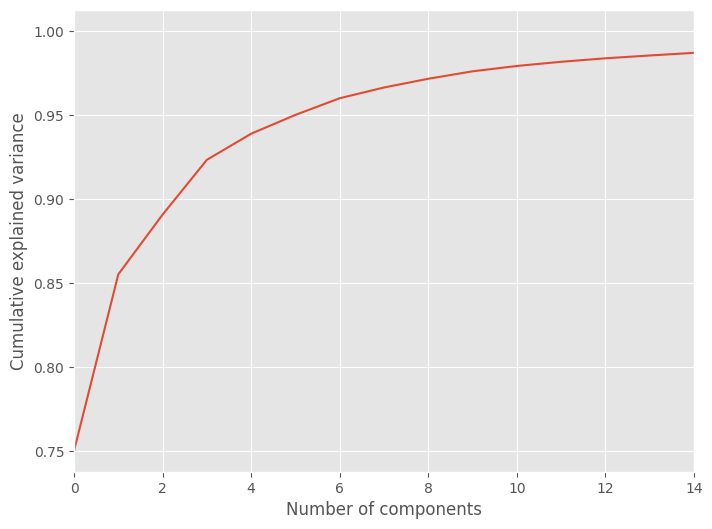

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,14,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [ ]:
pca = PCA(n_components=pca_dim)
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[0.750442   0.10482399 0.0354786  0.03255986]


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_pca,y,test_size=0.2)
for i in [X_train,X_test,y_train,y_test]:
    print("Shape of Data is {}".format(i.shape))

Shape of Data is (255, 4)
Shape of Data is (64, 4)
Shape of Data is (255,)
Shape of Data is (64,)


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
for i in [X_train,X_test,y_train,y_test]:
    print("Shape of Data is {}".format(i.shape))

from sklearn.cross_decomposition import PLSRegression
model = PLSRegression(n_components=pca_dim)
# fitting the model
model.fit(X_train, y_train)

# making predictions
y_pred = model.predict(X_test)

r2 = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print('R2 Score is : {} | Root Mean Square Error is : {}'.format(r2,rmse))

Shape of Data is (255, 62)
Shape of Data is (64, 62)
Shape of Data is (255,)
Shape of Data is (64,)
R2 Score is : 0.5465770860459889 | Root Mean Square Error is : 0.22018326947632347


In [ ]:
## Testing our model
tmp_df = y_test.to_frame()
tmp_df['pred'] = y_pred.tolist()
tmp_df

,ddG,pred
875,0.289947,0.458428
603,0.048594,0.458428
1803,0.361441,0.458428
342,0.037919,0.458428
127,1.559882,0.458428
...,...,...
948,0.308875,0.458428
1619,0.141633,0.458428
1681,0.055715,0.458428
1555,0.003554,0.458428


In [ ]:
from joblib import dump, load
dump(model, resolve_path_gdrive('models/pls_large.joblib'))
clf2 = load(resolve_path_gdrive('models/pls_large.joblib'))

In [ ]:
df_pred = df[1:5]
X_pred = df_pred[high_corr_rows.keys()]
y_pred = df_pred['ddG']
y_pred2 = clf2.predict(X_pred)

In [ ]:
tmp_df = y_pred.to_frame()
tmp_df['pred'] = y_pred2.tolist()
tmp_df

,ddG,pred
1,0.719002,[1.0918201102818612]
10,0.631877,[0.5847719015935183]
16,0.216792,[0.2587352704606415]
17,0.111677,[0.2587352704606415]


In [ ]:
y_pred2 = clf2.predict(X_pred.iloc[2].to_numpy().reshape(1,-1))

C:\work\workspaces\python\miniconda3\envs\ml2\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PLSRegression was fitted with feature names
  warnings.warn(


In [ ]:
X = df[df.columns[~df.columns.isin(['Catalyst', 'ddG'])]] # high_corr_rows.keys() OR df.columns[~df.columns.isin(['Catalyst', 'ddG'])]
y = df['ddG']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
for i in [X_train,X_test,y_train,y_test]:
    print("Shape of Data is {}".format(i.shape))

from sklearn.linear_model import Lasso

model = Lasso(alpha=0.0001)
model.fit(X_train, y_train)

# making predictions
y_pred = model.predict(X_test)

r2 = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print('R2 Score is : {} | Root Mean Square Error is : {}'.format(r2,rmse))

Shape of Data is (255, 3974)
Shape of Data is (64, 3974)
Shape of Data is (255,)
Shape of Data is (64,)
R2 Score is : 0.5785562854353197 | Root Mean Square Error is : 0.3031214099054295


In [ ]:
X = df[df.columns[~df.columns.isin(['Catalyst', 'ddG'])]] # high_corr_rows.keys() OR df.columns[~df.columns.isin(['Catalyst', 'ddG'])]
y = df['ddG']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
for i in [X_train,X_test,y_train,y_test]:
    print("Shape of Data is {}".format(i.shape))

# Lets train our model on training data and predict also on training to see results
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_train)
r2 = r2_score(y_train,y_pred)
rmse = np.sqrt(mean_squared_error(y_train,y_pred))
print('R-Squared Score is : {} | Root Mean Square Error is : {}'.format(r2,rmse))

Shape of Data is (255, 3974)
Shape of Data is (64, 3974)
Shape of Data is (255,)
Shape of Data is (64,)
R-Squared Score is : 0.8856918964763432 | Root Mean Square Error is : 0.1407639594970315


In [ ]:
# Lets train our model on training data and predict on testing to see results
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
r2 = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print('R2 Score is : {} | Root Mean Square Error is : {}'.format(r2,rmse))

R2 Score is : -4.065145957139249e+20 | Root Mean Square Error is : 8660800427.264627


## Subset Selection Methods
Here we implement methods that reduce the number of parameters

### Forward Selection
We will  apply the forward-selection approach


In [ ]:
!pip install ISLP
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)

0

In [ ]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [ ]:
df_cleaned.head()

,1,2,3,4,5,6,7,8,9,10,...,3965,3966,3967,3968,3969,3970,3971,3972,3973,ddG
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.833714,-0.605952,-0.471700,-0.768480,-0.178536,-0.298590,-0.238640,-0.277510,-0.230633,-0.672194
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.880495,-0.602624,-0.471616,-0.798242,-0.277709,-0.280445,-0.279338,-0.246094,-1.153164,-1.146684
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.104378,1.789966,1.707972,-0.078629,-1.416062,-1.347984,-1.383415,0.492188,0.691898,0.276786
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.938972,-0.643031,-0.505083,-0.825677,-0.297732,-0.236059,-0.267225,0.028798,-0.691898,-0.672194
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.112732,0.601039,0.691527,1.360684,0.614598,0.524781,0.570340,-1.518452,-0.230633,1.463011


We first choose the best model using forward selection based on $C_p$. We define a function to compute it as its not built in as a metric to `sklearn`. By default, `sklearn` tries to maximize a score, hence
  our scoring function  computes the negative $C_p$ statistic.

In [ ]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n


In [ ]:
design = MS(df_cleaned.columns.drop('ddG')).fit(df_cleaned)
Y = np.array(df_cleaned['ddG'])
X = design.transform(df_cleaned)
sigma2 = OLS(Y,X).fit().scale

In [ ]:
neg_Cp = partial(nCp, sigma2)

We can now use `neg_Cp()` as a scorer for model selection.

Along with a score we need to specify the search strategy. This is done through the object
`Stepwise()`  in the `ISLP.models` package. The method `Stepwise.first_peak()`
runs forward stepwise until any further additions to the model do not result
in an improvement in the evaluation score. Similarly, the method `Stepwise.fixed_steps()`
runs a fixed number of steps of stepwise search.

In [ ]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))


We now fit a linear regression model with `Salary` as outcome using forward
selection. To do so, we use the function `sklearn_selected()`  from the `ISLP.models` package. This takes
a model from `statsmodels` along with a search strategy and selects a model with its
`fit` method. Without specifying a `scoring` argument, the score defaults to MSE, and so all 19 variables will be
selected.

In [ ]:
hitters_MSE = sklearn_selected(OLS,
                               strategy)
hitters_MSE.fit(df_cleaned, Y)
hitters_MSE.selected_state_


('3954', '3955', '3964', '3968', '3970')

Using `neg_Cp` results in a smaller model, as expected, with just 10 variables selected.

In [ ]:
hitters_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring=neg_Cp)
hitters_Cp.fit(df_cleaned, Y)
hitters_Cp.selected_state_


('2595', '3489', '3955', '3960', '3964', '3968', '3970')

### Choosing Among Models Using the Validation Set Approach and Cross-Validation

As an  alternative to using $C_p$, we might try cross-validation to select a model in forward selection. For this, we need a
method that stores the full path of models found in forward selection, and allows predictions for each of these. This can be done with the `sklearn_selection_path()`
estimator from `ISLP.models`. The function `cross_val_predict()` from `ISLP.models`
computes the cross-validated predictions for each of the models
along the path, which we can use to evaluate the cross-validated MSE
along the path.

Here we define a strategy that fits the full forward selection path.
While there are various parameter choices for `sklearn_selection_path()`,
we use the defaults here, which selects the model at each step based on the biggest reduction  in RSS.

In [ ]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')
full_path = sklearn_selection_path(OLS, strategy)


We now fit the full forward-selection path on the `Hitters` data and compute the fitted values.

In [ ]:
full_path.fit(df_cleaned, Y)
Yhat_in = full_path.predict(df_cleaned)
Yhat_in.shape


This gives us an array of fitted values --- 20 steps in all, including the fitted mean for the null model --- which we can use to evaluate
in-sample MSE. As expected, the in-sample MSE improves each step we take,
indicating we must use either the validation or cross-validation
approach to select the number of steps. We fix the y-axis to range from
50,000 to 250,000 to compare to the cross-validation and validation
set MSE below, as well as other methods such as ridge regression, lasso and
principal components regression.

In [ ]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000,250000]);


from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)